<a href="https://colab.research.google.com/github/HyberionBrew/skylab_vae/blob/main/vae_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls 

dataset      drive	__pycache__   sample_data		    unet
dataset.zip  metric.py	Pytorch-UNet  Segmentation-Metrics-PyTorch


In [3]:
!cp drive/MyDrive/dataset.zip dataset.zip

In [59]:
%%capture
!unzip dataset.zip

In [4]:
!ls dataset

after  after_label  before  before_label  diff_label


In [5]:
%%capture
!pip install rasterio
!pip install geopandas
!pip install albumentations==0.4.6

In [6]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from descartes import PolygonPatch
from PIL import Image
import itertools
import re
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# import imgaug
import random
import albumentations

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%matplotlib inline

In [7]:
import cv2

In [8]:
total_indx = 2
img1 = cv2.imread('./dataset/before/%06d.png'%total_indx)
img2 = cv2.imread('./dataset/after/%06d.png'%total_indx)
mask1 = torch.load('./dataset/before_label/%06d.pth'%total_indx)
mask2 = torch.load('./dataset/after_label/%06d.pth'%total_indx)
mask_diff = torch.load('./dataset/diff_label/%06d.pth'%total_indx)

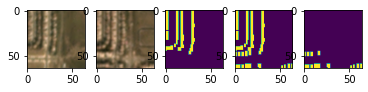

In [9]:
# plt.figure(figsize=(4, 4), dpi=80)
plt.subplot(2, 5, 1)
plt.imshow(img1)

plt.subplot(2, 5, 2)
plt.imshow(img2)

plt.subplot(2, 5, 3)
plt.imshow(mask1)

plt.subplot(2, 5, 4)
plt.imshow(mask2)
plt.subplot(2, 5, 5)
plt.imshow(mask_diff)

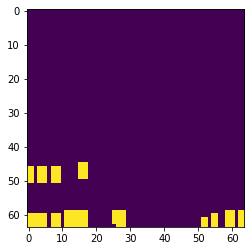

In [10]:
#%%
plt.imshow(mask_diff)

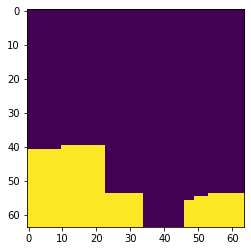

In [11]:
plt.imshow(cv2.GaussianBlur(mask_diff.astype(float),(11, 11), 0) > 0.)

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [13]:
#%%
import glob

In [14]:
paths = glob.glob('./dataset/before/*')


In [15]:
class MyDataset(Dataset):
    def __init__(self, transform=None):
        self.paths = glob.glob('./dataset/before/*')
        self.transform = transform
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img1 = cv2.imread(self.paths[idx])
        img2 = cv2.imread(self.paths[idx].replace('before','after'))
        label2 = torch.load(self.paths[idx].replace('before','diff_label').replace('png','pth'))
        # why do we use label2 here?
        label1 = cv2.GaussianBlur(label2.astype(float),(11, 11), 0) > 0.
        
        if self.transform:
            transformed1 = self.transform(image = img1,label = label1)
            transformed2 = self.transform(image = img2,label = label2)
        img1 = transformed1['image']
        label1 = transformed1['label']
        img2 = transformed2['image']
        label2 = transformed2['label']
        return img1,img2, label1,label2


In [16]:
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ]
)

In [17]:
dataset = MyDataset(transform)
img1,img2, label1,label2 = dataset[2000]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


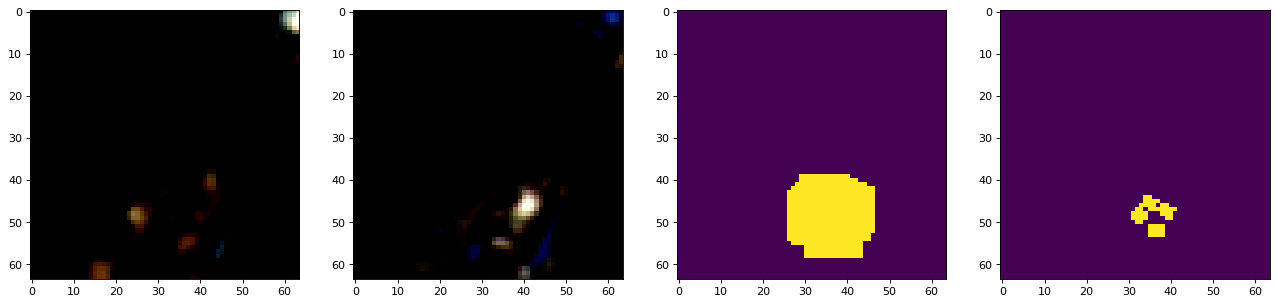

In [18]:
plt.figure(figsize=(20, 20), dpi=80)
plt.subplot(2, 4, 1)
plt.imshow(img1.permute(1,2,0))

plt.subplot(2, 4, 2)
plt.imshow(img2.permute(1,2,0))

plt.subplot(2, 4, 3)
plt.imshow(label1)

plt.subplot(2, 4, 4)
plt.imshow(label2)

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
import math

train_size = math.floor(0.8 * len(dataset))
test_size = len(dataset)- train_size

np.random.seed(42)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
train_indices, val_indices = indices[train_size:], indices[:train_size]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(val_indices)

batch_size = 32
num_workers = 3
train_loader = DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
test_loader = DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler, num_workers=num_workers)

In [77]:
#dataloader = DataLoader(dataset, batch_size=8,
#                        shuffle=False, num_workers=3)

In [78]:
!git clone https://github.com/milesial/Pytorch-UNet

fatal: destination path 'Pytorch-UNet' already exists and is not an empty directory.


In [79]:
!ls unet

__init__.py  __pycache__  unet_model.py  unet_parts.py


In [80]:
!cp -r Pytorch-UNet/unet/ unet/

In [20]:
import sys
import os
sys.path.append(os.path.abspath("unet/*"))
from unet.unet_parts import *
from unet.unet_model import UNet

In [100]:
!git clone https://github.com/hsiangyuzhao/Segmentation-Metrics-PyTorch.git

Cloning into 'Segmentation-Metrics-PyTorch'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [21]:
!cp Segmentation-Metrics-PyTorch/metric.py metric.py

In [22]:
from metric import BinaryMetrics

In [194]:
model = UNet(4,4).cuda()
#model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5)

In [195]:
optimizer = torch.optim.SGD(model.parameters(),
                            lr=1e-3,
                            momentum=4e-5,
                            weight_decay=0.9)

In [196]:
loss_function = torch.nn.MSELoss().cuda()

In [197]:
def metric(outputs: torch.Tensor, labels: torch.Tensor):
    # y_true: (N, H, W)
    # y_pred: (N, 1, H, W)
    bn = BinaryMetrics()
    metrics = bn(labels,outputs)
    #print(metrics)
    return metrics

In [181]:
pixel_acc_all = []
dice_all = [] 
precision_all = [] 
specificity_all = [] 
recall_all = []

def test_loop(model, test_dataset):
    computeExample = True
    example = np.zeros((batch_size,64,64))
    example_label = torch.tensor(np.zeros((batch_size,64,64)))
    for img1,img2, label1,label2 in tqdm(test_dataset):
        img1 = img1.cuda()
        img2 = img2.cuda()
        label1 = label1.cuda()
        label2 = label2.cuda()
        with torch.no_grad():
            #sig = torch.nn.Sigmoid()
            output = model(torch.cat([img1,label1.unsqueeze(1)],dim=1))
            out_mask = output[:,-1,:,:]
            #out_mask = sig(out_mask.unsqueeze(1))
        out_image = output[:,:-1,:,:]
       
         # torch.nn.functional.softmax(out_mask, dim=)
        final_mask = out_mask.unsqueeze(1).cpu() #.detach().numpy()
        #final_mask = np.zeros_like(det_mask)
        #final_mask[det_mask>0.5] = 1
        
        pixel_acc, dice, precision, specificity, recall = metric(final_mask,label2.cpu())
        
        pixel_acc_all.append(float(pixel_acc.data.cpu()))
        dice_all.append(float(dice.data.cpu()))
        precision_all.append(float(precision.data.cpu()))
        specificity_all.append(float(specificity.data.cpu()))
        recall_all.append(float(recall.data.cpu()))

        # compute example
        if computeExample:
            sig = torch.nn.Sigmoid()
            final_mask = sig(final_mask)
            final_mask = final_mask.cpu().detach().numpy()
            
            example = np.zeros_like(final_mask)
            example[final_mask>0.5] = 1
            computeExample = False
            example_label = label2.unsqueeze(1).cpu()

        
    means = [np.mean(pixel_acc_all), np.mean(dice_all), np.mean(precision_all), np.mean(specificity_all),np.mean(recall_all)]
    print(f"Pixel acc {means[0]}; Dice {means[1]}; Precision {means[2]}; Specifity {means[3]}; Recall{means[4]}")
    return means, torch.tensor(example), example_label
        


In [182]:
import torch
import numpy as np

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        img_gray = np.mean(img, axis=2)
        axs[0, i].imshow(np.asarray(img_gray),cmap=plt.get_cmap('RdYlGn'))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [183]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
def show_batch_images(examples, amount:int):
    grid = make_grid(examples)
    show(grid)

In [189]:
epoch = 10
losses = []
examples = []
metrics_all = []
for e in range(epoch):
    print(f"epoch {e}")
    iters = 0
    losses_epoch = []
    for img1,img2, label1,label2 in tqdm(train_loader):
        img1 = img1.cuda()
        img2 = img2.cuda()
        label1 = label1.cuda()
        label2 = label2.cuda()
        output = model(torch.cat([img1,label1.unsqueeze(1)],dim=1))
        gt = torch.cat([img2,label2.unsqueeze(1)],dim=1)
        loss = loss_function(output,gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses_epoch.append(float(loss))
        
        if iters%100 == 0:
            #print(float(loss))
            pass
        iters += 1
    print(f"Running testing - average loss across epoch: {np.mean(losses_epoch)}")
    losses = np.append(losses, losses_epoch)
    metrics, example, example_label = test_loop(model,test_loader)
    examples.append((example,example_label))
    metrics_all.append(metrics)
    #show_batch_images(example,16)
    #show_batch_images(example_label,16)

epoch 0


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.25465528666973114


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4423767879163902; Dice 0.07138586101720384; Precision 0.037254806275171845; Specifity 0.430696561513521; Recall0.9461550555695833
epoch 1


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.25913713686168194


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4374906229776575; Dice 0.07098157936407143; Precision 0.03703323498124266; Specifity 0.4256621319520619; Recall0.9477974105794342
epoch 2


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.26503800973296165


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.43192970093616434; Dice 0.07053149274293077; Precision 0.036787849384494246; Specifity 0.4199358093558987; Recall0.9493024842415065
epoch 3


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.26444638706743717


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4261343506093961; Dice 0.07005498167726253; Precision 0.03652914776650118; Specifity 0.4139761254533617; Recall0.9507218750286603
epoch 4


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.26560116512700915


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4200751653384036; Dice 0.06956549600001395; Precision 0.03626307667387048; Specifity 0.4077453345905139; Recall0.9520664009897728
epoch 5


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2640054076910019


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4140739848917358; Dice 0.06909059388602523; Precision 0.0360051795861699; Specifity 0.4015731245532027; Recall0.953383188421693
epoch 6


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.27011815644800663


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.40788689781535503; Dice 0.06860007730862096; Precision 0.03573886754323144; Specifity 0.3952150952584822; Recall0.954628688178698
epoch 7


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2713108668103814


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.4018501543321545; Dice 0.068135066671848; Precision 0.03548695350351824; Specifity 0.3890098317854182; Recall0.9558565434407866
epoch 8


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2804298037663102


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.3957523349596695; Dice 0.06766709097350805; Precision 0.03523361163166815; Specifity 0.38274440693686973; Recall0.9570228902988708
epoch 9


  0%|          | 0/32 [00:00<?, ?it/s]

Running testing - average loss across epoch: 0.2703566667623818


  0%|          | 0/127 [00:00<?, ?it/s]

Pixel acc 0.3895329859899724; Dice 0.06719980846034494; Precision 0.034981064095095854; Specifity 0.37635414627749775; Recall0.9581391984239964


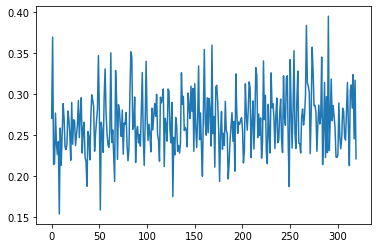

In [190]:
plt.plot(losses)

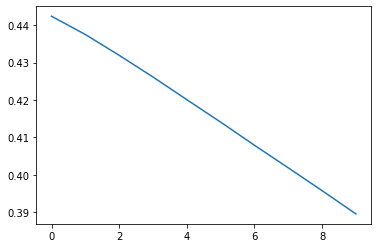

In [191]:
plt.plot([metr[0] for metr in metrics_all])

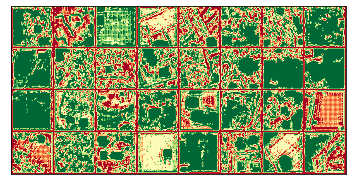

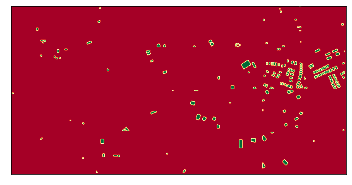

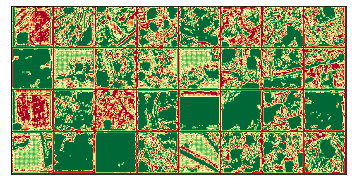

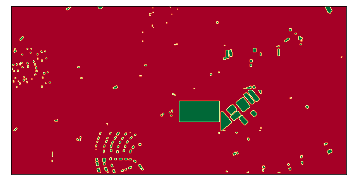

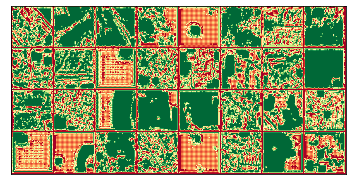

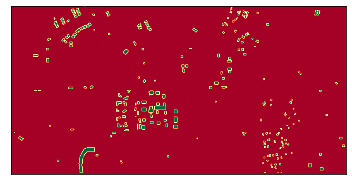

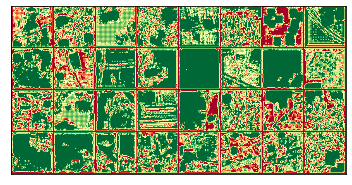

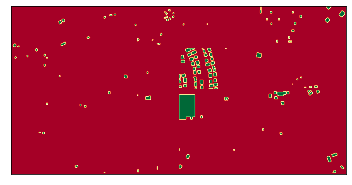

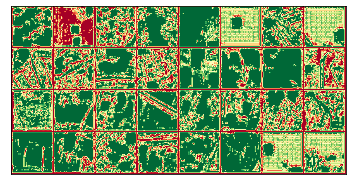

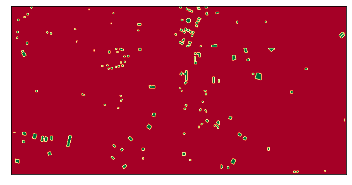

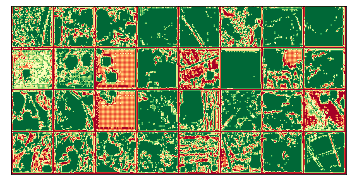

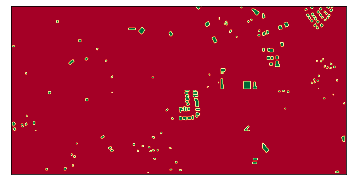

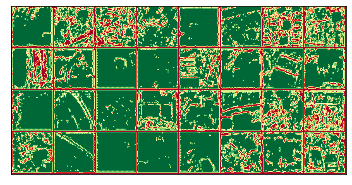

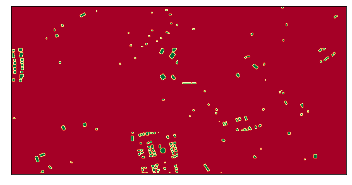

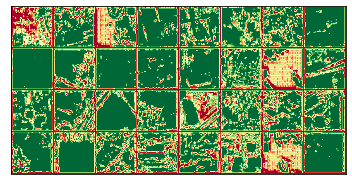

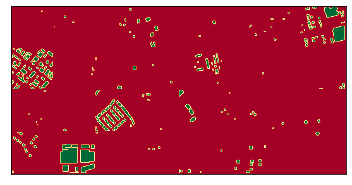

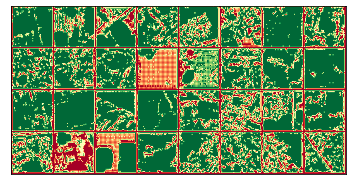

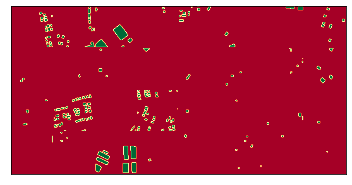

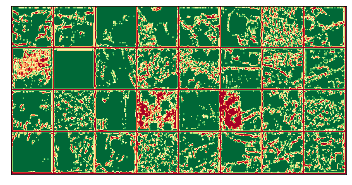

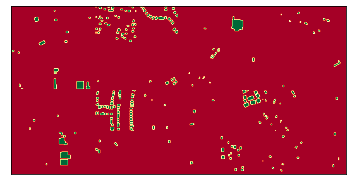

In [193]:
for example in examples:
    show_batch_images(example[0],16)
    show_batch_images(example[1],16)